# Modelos de Clustering - Aprendizaje No Supervisado

## 1 Objetivos y Perspectiva general

En este notebook vamos a trabajar en un caso práctico de clasificaciones de tipos de pingüinos ([penguins](https://www.kaggle.com/datasets/youssefaboelwafa/clustering-penguins-species)) generando clusters.


<section style="width: 100%;"> 
	<div style="width: 50%; float: left; border-radius: 10px;"> 
        El objetivo es diferenciar las especies de pinguinos que encontramos dentro del dataset. Para ello utilizaremos clustering, uno de los tipos de aorendizaje no supervisado.
        Para ello contamos con los siguentes datos de 321 ejemplares de pinguinos, con la siguiente información:
        <ol>
            <li><em>culmen</em> o <em>bill length</em> (longitud del pico) en milímetros.</li>
            <li><em>culmen</em> o <em>bill depth</em> (ancho del pico) en milímetros.</li>
            <li><em>flipper length</em> (longitud de la aleta) en milímetros.</li>
            <li><em>body mass</em> (masa corporal) en gramos.</li>
            <li><em>sex</em> (sexo), macho o hembra.</li>
        </ol>
	</div> <div style="width: 50%; float: left;">
		<img src="https://user-images.githubusercontent.com/54525819/139198017-769e8f61-2e58-48a9-947d-fd22947a6548.png" />
	 </div>
</section>


¡Comencemos!

## 2 Importación de librerías y paquetes

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Modelos
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.decomposition import PCA
# Metricas
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree

import warnings
warnings.filterwarnings("ignore")

## 3 Lectura y visualización de datos

In [33]:
df = pd.read_csv(r".\datasets\penguins\penguins.csv")
df.head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,39.1,18.7,181.0,3750.0,MALE
1,39.5,17.4,186.0,3800.0,FEMALE
2,40.3,18.0,195.0,3250.0,FEMALE
3,NaN,NaN,NaN,NaN,NaN
4,36.7,19.3,193.0,3450.0,FEMALE


Podemos ver que el dataset tiene multiples valores en `NULL`. Como son pocos, lo que haremos será borrar directamente las filas que los contengan.

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   culmen_length_mm   342 non-null    float64
 1   culmen_depth_mm    342 non-null    float64
 2   flipper_length_mm  342 non-null    float64
 3   body_mass_g        342 non-null    float64
 4   sex                335 non-null    object 
dtypes: float64(4), object(1)
memory usage: 13.6+ KB


In [35]:
df.isnull().sum()

culmen_length_mm     2
culmen_depth_mm      2
flipper_length_mm    2
body_mass_g          2
sex                  9
dtype: int64

In [36]:
df.dropna(inplace=True)

df.isnull().sum()

culmen_length_mm     0
culmen_depth_mm      0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64

Estos datos nos indican que *flipper_lenght_mm* puede estar teniendo _outlayers_, es decir, valores, que por algún motivo, estan fuera de rango (mala medición, error en la transcripción, valor no resentativo, etc.). Así pues, procedemos a eliminarlos para que no interfieran en la clasificación posterior.

In [37]:
df.describe()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
count,335.000000,335.000000,335.000000,335.000000
mean,43.988358,17.169552,214.355224,4209.179104
std,5.453430,1.971966,263.253508,803.633495
min,32.100000,13.100000,-132.000000,2700.000000
25%,39.500000,15.600000,190.000000,3550.000000
50%,44.500000,17.300000,197.000000,4050.000000
75%,48.550000,18.700000,213.000000,4787.500000
max,59.600000,21.500000,5000.000000,6300.000000


In [38]:
q_low = df["flipper_length_mm"].quantile(0.01)
q_hi  = df["flipper_length_mm"].quantile(0.99)
df = df[(df['flipper_length_mm'] < q_hi) & (df['flipper_length_mm'] > q_low)]

También hemos encontrado un valor erroneo en el sexo de los pinguinos, ya sea porque hay un error o no se pudo determinar, en el sexo del animal no deberia aparecer el atributo `'.'`.

In [39]:
df['sex'].unique()

array(['MALE', 'FEMALE', '.'], dtype=object)

In [40]:
df = df[~(df['sex'] == '.')]

In [41]:
df.reset_index(drop=True, inplace=True)

## 4 Exploración de los datos (EDA)

Una vez limipios los datos, podemos ver la distribución de los datos:

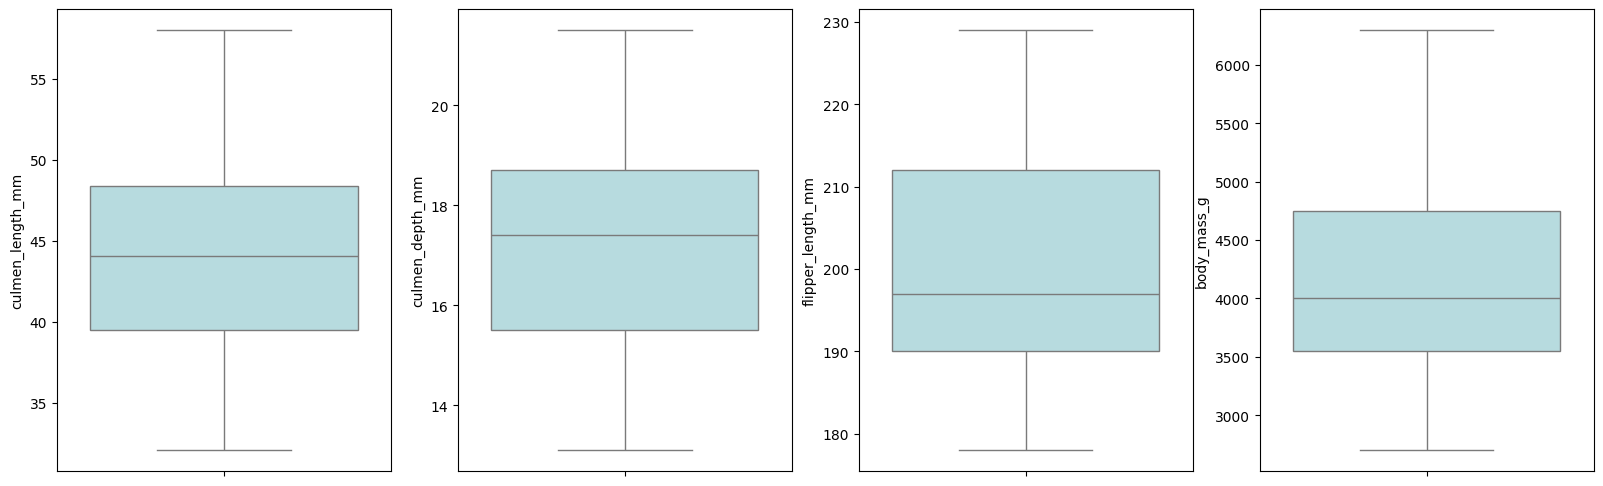

In [42]:
fig = plt.figure(figsize=(25, 6))

for i, column in enumerate(df.columns[:-1]):
    sub = fig.add_subplot(1, 5, i + 1)
    sns.boxplot(data=df, y=column, color='powderblue')

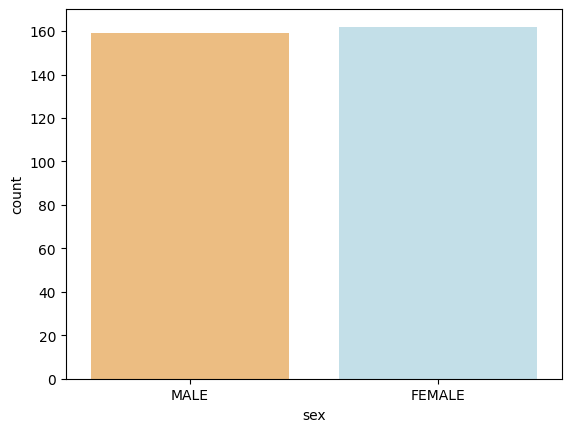

In [43]:
sns.countplot(x=df['sex'], hue=df['sex'], palette='RdYlBu')
plt.show()

Las categorias con strings dan problemas al momento de trabajar con ellas en un modelo. Por ello simplemente cambiaremos el valor del sexo a un número que siga representando su valor. 

In [44]:
df['sex'] = pd.factorize(df['sex'])[0]

In [45]:
df.head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,39.1,18.7,181.0,3750.0,0
1,39.5,17.4,186.0,3800.0,1
2,40.3,18.0,195.0,3250.0,1
3,36.7,19.3,193.0,3450.0,1
4,39.3,20.6,190.0,3650.0,0


Una vez más, estandarizaremos los datos para asegurarnos de que aplicaremos la uniformidad necesaria para garantizar la efectividad de sus análisis.

In [46]:
Scaler = StandardScaler()
scaled = Scaler.fit_transform(df)

df = pd.DataFrame(scaled, columns=df.columns)
df.head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,-0.895481,0.774403,-1.474530,-0.549081,-1.009390
1,-0.820183,0.118776,-1.096476,-0.484754,0.990697
2,-0.669587,0.421373,-0.415978,-1.192347,0.990697
3,-1.347268,1.077000,-0.567200,-0.935040,0.990697
4,-0.857832,1.732627,-0.794032,-0.677734,-1.009390


Aplicaremos PCA para reducir el número de características para ser más fáciles de manejar. En este caso, estamos elegiendo el número óptimo de componentes principales para preservar la mayor varianza posible.

In [47]:
#composición del PCA
pca = PCA(n_components=None)
pca_data = pca.fit(df)

pca_data.explained_variance_ratio_

array([0.55573382, 0.28575818, 0.10288218, 0.03435194, 0.02127388])

In [48]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(df)

## 5 Comparación de Modelos

A continuación, procedemos a aplicar una serie de algoritmos de clústering con el objetivo de verificar cuál nos proporciona un resultado final óptimo para la clasificación de los grupos de pingüinos.mucho)

## K-Means
El primer modelo que validaremos será el K-Means, el cuál consiste en buscar los centros de los cúmulos de datos y asociarlos con un centroide. El número de grupos que generamos lo decidimos nosotros. Una técnica para hacerlo es la de _elbow method_ o método del codo, donde probando diferentes números de centros, vemos la variación de los resultados. Una vez obtenidos, se genera un gráfico con una curva descendiente. El punto de más que quedaría situado en el codo es el número de grupos ideales para nuestro _dataset_.

In [72]:
wcss = []   # within cluster sum of squares
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(pca_data)
    wcss.append(kmeans.inertia_)

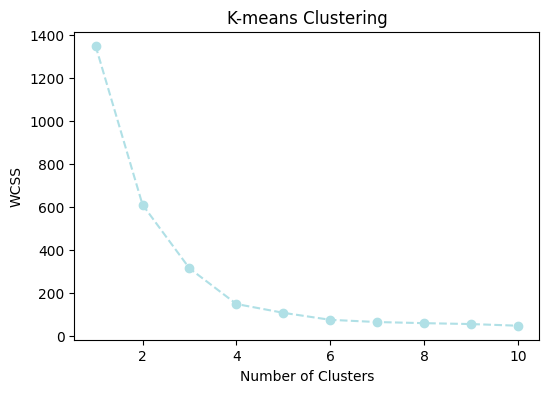

In [74]:
plt.figure(figsize=(6, 4))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--', color="powderblue")
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('K-means Clustering')
plt.show()

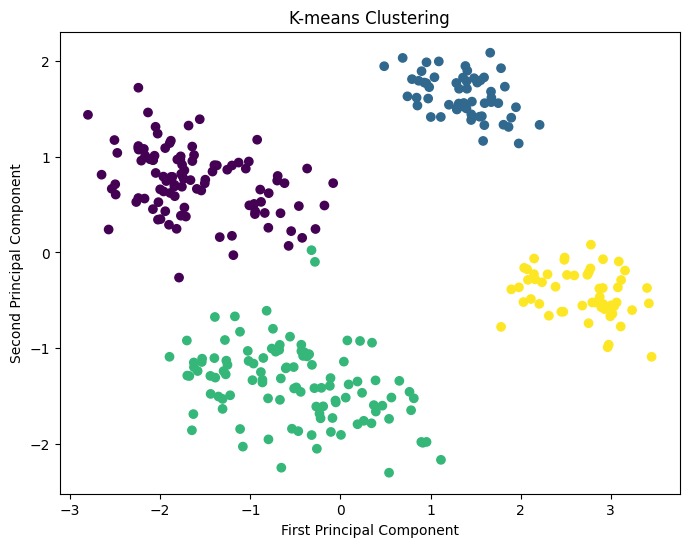

In [77]:
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42)
kmeans.fit(pca_data)

plt.figure(figsize=(8, 6))
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=kmeans.labels_, cmap='viridis')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('K-means Clustering')
plt.show()

Por último, en la aplicación del Kmeans calcularemos el "Silhouette Score", una métrica que evalúa la calidad de un modelo de clustering. Esta métrica mide qué tan bien están separados los clusters y qué tan cohesionados están sus puntos internos. Es decir, indica qué tan adecuadamente cada punto de un cluster está agrupado con los puntos de su mismo cluster y qué tan lejos está de los puntos de otros clusters.

In [52]:
silhouette_score(pca_data, kmeans.labels_)

print(f"The silhouette score for K-means algorithm is: {silhouette_score(pca_data, kmeans.labels_):.2f}")

The silhouette score for K-means algorithm is: 0.65


Hemos obtenido un resultado de 0.65 para el Silhouette Score, un valor realmente bueno, pues indica que los clusters están bien formados en la mayoría de los casos.

# K-Medoids

Otro modelo muy popular en clústering es el K-Medoids. A diferencia de K-Means, K-Medoids usa como centro puntos conocidos de los datos, buscando cuál cumple con la menor distancia entre ellos. Esto los hace más resistentes al ruido o los valores anómalos, pero son más costosos computacionalmente.

In [79]:
wcss = []   # within cluster sum of squares
for i in range(1, 11):
    kmedoids = KMedoids(n_clusters=i, random_state=42)
    kmedoids.fit(pca_data)
    wcss.append(kmedoids.inertia_)

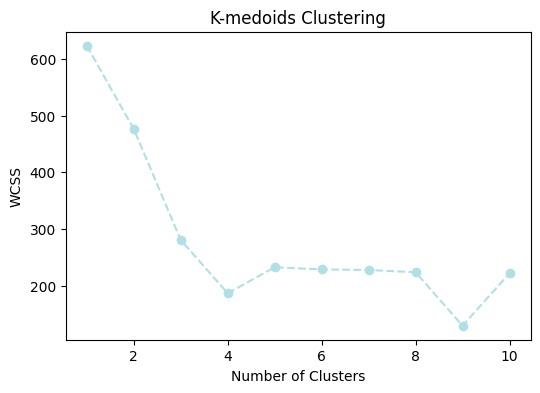

In [80]:
plt.figure(figsize=(6, 4))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--', color='powderblue')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('K-medoids Clustering')
plt.show()

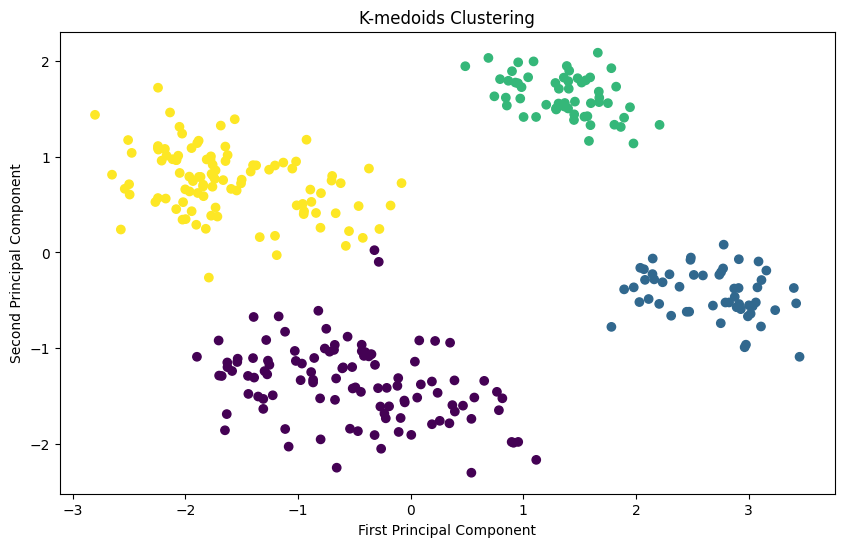

In [54]:
# kmedoids
kmedoids = KMedoids(n_clusters=4, random_state=42)
kmedoids.fit(pca_data)

# plot the clusters
plt.figure(figsize=(10, 6))
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=kmedoids.labels_, cmap='viridis')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('K-medoids Clustering')
plt.show()

Procedemos a calcular el "Silhouette Score" para evaluar la calidad del modelo. 

In [55]:
# compute the silhouette score
silhouette_score(pca_data, kmedoids.labels_)
print(f"The silhouette score for K-medoids algorithm is: {silhouette_score(pca_data, kmedoids.labels_):.2f}")

The silhouette score for K-medoids algorithm is: 0.65


Al igual que en el modelo de K-Means, hemos obtenido un resultado de 0.65 en el Silhouette Score aplicando el modelo de K-Medoids, lo cual indica que los clusters están bien formados en la mayoría de los casos.

## Clustering Jerárquico

Clustering jerárquico es una técnica de aprendizaje no supervisado que organiza un conjunto de datos en grupos (clusters) siguiendo una estructura jerárquica, similar a un árbol. Su objetivo es agrupar elementos similares entre sí en diferentes niveles, de modo que los clusters más pequeños se integran en clusters más grandes a medida que avanzamos en la jerarquía.

Hay dos tipos de enfoques para crear una jerarquía de clusters:
- Aglomerativo (de abajo a arriba).
- Divisiva (de arriba a abajo).

El método **aglomerativo** comienza considerando cada punto de datos como un cluster independiente. Luego, el algoritmo va fusionando iterativamente los clusters más similares en un solo grupo, hasta que todos los datos forman un único cluster.

Por otro lado, el enfoque **divisivo** hace lo contrario: parte de un único cluster que contiene todos los datos y los va dividiendo en subgrupos más pequeños.

Hay varias formas de combinar los clusters calculando las distancias entre:
1. Centroides de cada cluster (average linkage o promedio de cada grupo).
2. Puntos más cercanos a cada cluster (single linkage o enlace único).
3. Puntos más lejanos de cada cluster (complete linkage o vínculo completo)
   
En el presente artículo nos centraremos en analizar el método aglomerativo en modelos de clustering jerárquico. 

Empezamos nuestro análisis explorando el **single linkage**, el cual se basa en calcular la distancia mínima entre cualquier par de puntos, donde cada punto pertenece a uno de los dos clusters que se están comparando.

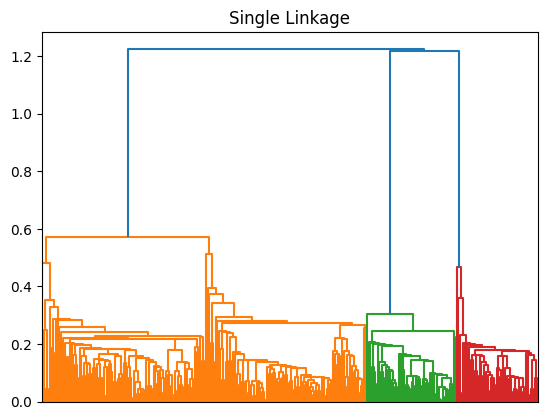

In [81]:
# single linkage
single_linkage = linkage(pca_data, method='single', metric='euclidean')

dendrogram(single_linkage)
plt.title('Single Linkage')
plt.gca().set_xticklabels([])
plt.show()

A continuación, analizaremos el método del **complete linkage**, el cual se basa en calcular la distancia máxima entre cualquier par de puntos, donde cada punto pertenece a uno de los dos clusters que se están comparando.

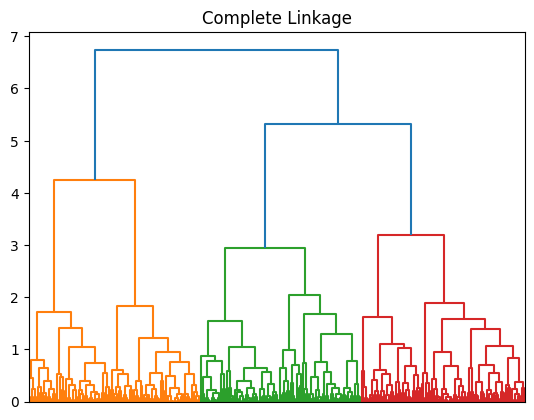

In [82]:
# complete linkage

complete_linkage = linkage(pca_data, method='complete', metric='euclidean')

dendrogram(complete_linkage)
plt.gca().set_xticklabels([])
plt.title('Complete Linkage')
plt.show()

Por último, analizaremos el **average linkage**, el cual  se basa en calcular la distancia promedio entre todos los pares de puntos, donde cada par contiene un punto de cada uno de los dos clusters que se están comparando.

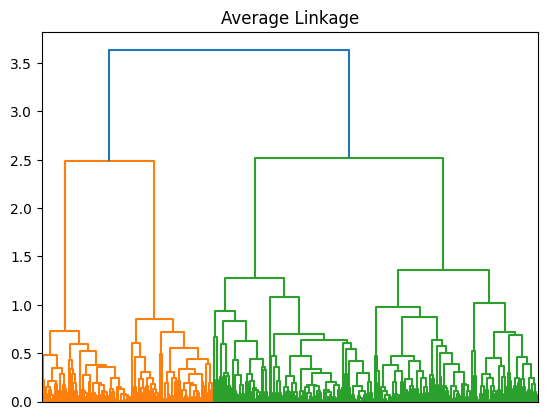

In [83]:
# average linkage

average_linkage = linkage(pca_data, method='average', metric='euclidean')

dendrogram(average_linkage)
plt.title('Average Linkage')
plt.gca().set_xticklabels([])
plt.show()

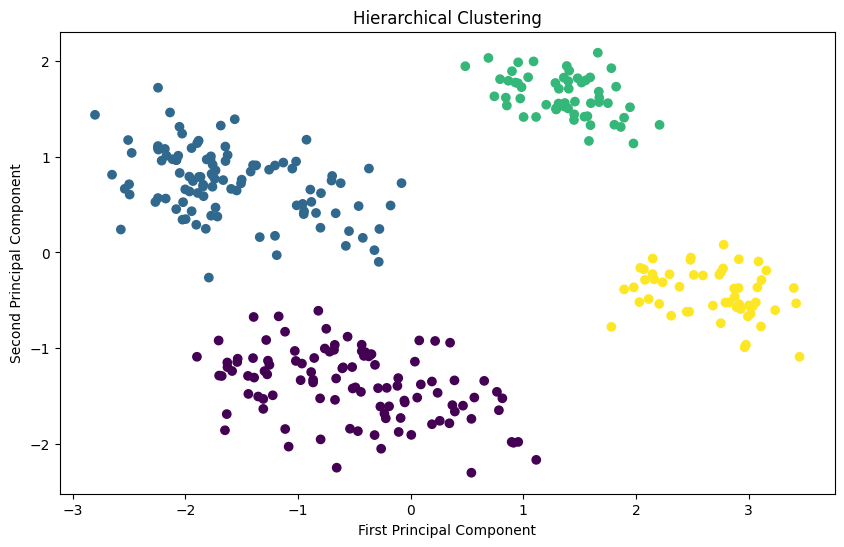

In [61]:
cluster_labels = pd.Series(cut_tree(average_linkage, n_clusters=4).reshape(-1,))

# plot the clusters
plt.figure(figsize=(10, 6))
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=cluster_labels, cmap='viridis')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('Hierarchical Clustering')
plt.show()

Al igual que en los anteriores modelos, procedemos a calcular el "Silhouette Score" para evaluar la calidad del modelo

In [62]:
# compute the silhouette score
silhouette_score(pca_data, cluster_labels)
print(f"The silhouette score for Hierarchical algorithm is: {silhouette_score(pca_data, cluster_labels):.2f}")

The silhouette score for Hierarchical algorithm is: 0.65


Hemos obtenido un resultado de 0.65 para el Silhouette Score aplicando Clustering jerárquico, el cual indica que los clusters están bien formados en la mayoría de los casos.

Por lo tanto, aplicando los tres modelos hemos llegado a la conclusión de que los clusters / agrupaciones se componen de forma correcta. Sin embargo, sería necesario seguir haciendo pruebas y entrenando los modelos con más datos para llegar a obtener mejores resultados.

#### ¡Muchas gracias por leer nuestro artículo!